# Electric Vehicle Lithium-ion Battery Ageing Analysis Under Dynamic Condition: A Machine Learning Approach

The study by Swarnkar, et al. investigates the challenges of monitoring and predicting the health of lithium-ion batteries, which are critical for electric vehicles. The paper highlights the importance of a robust battery management system (BMS) due to the non-linear degradation of batteries influenced by factors such as charge/discharge rates, temperature, and other operational conditions. By analyzing battery performance under various dynamic conditions, the study applies machine learning techniques such as Multiple Linear Regression, M-SVM and Neural Network (LSTM-GPR), to predict the battery's state of health (SOH).

## Loading the data

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
def load_mat(filepath):
    return sio.loadmat(filepath, simplify_cells=True)

**Data description:**

A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles (charge, discharge and impedance) at room temperature. Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz. Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses. The experiments were stopped when the batteries reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr). This dataset can be used for the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).

**Structure of .mat files:**

    dictionary (loaded mat file)
        dictionary (e.g. B0005)
            list (cycle) -> one test per element in the list
                element of the list = dict = all data for one test of that battery
                    type: operation type, can be charge, discharge or impedance
                    ambient_temperature: ambient temperature (degree C)
                    time: the date and time of the start of the cycle, in MATLAB date vector format
                    data (dict): data structure containing the measurements
                        data fields with key being measured variable, values the actual records (see below)

    for charge the fields are:
        Voltage_measured: Battery terminal voltage (Volts) 
        Current_measured: Battery output current (Amps)
        Temperature_measured: Battery temperature (degree C)
        Current_charge: Current measured at charger (Amps)
        Voltage_charge: Voltage measured at charger (Volts)
        Time: Time vector for the cycle (secs)
        
    for discharge the fields are:
        Voltage_measured: Battery terminal voltage (Volts)
        Current_measured: Battery output current (Amps)
        Temperature_measured: Battery temperature (degree C)
        Current_load: Current measured at load (Amps)
        Voltage_load: Voltage measured at load (Volts)
        Time: Time vector for the cycle (secs)
        Capacity: Battery capacity (Ahr) for discharge till 2.7V
        
    for impedance the fields are:
        Sense_current: Current in sense branch (Amps)
        Battery_current: Current in battery branch (Amps)
        Current_ratio: Ratio of the above currents
        Battery_impedance: Battery impedance (Ohms) computed from raw data
        Rectified_impedance: Calibrated and smoothed battery impedance (Ohms)
        Re: Estimated electrolyte resistance (Ohms)
        Rct: Estimated charge transfer resistance (Ohm)


## Storing the data into a dataframe

To streamline data access, we will organize the relevant information into a DataFrame and a dictionary for efficient storage and retrieval.

In [3]:
def get_charge_discharge_df(battery_cycles):
    charge_dfs = []
    discharge_dfs = []
    impedance_dfs = []

    c = 0
    d = 0
    i = 0

    for cycle_number in range(len(battery_cycles)):
        cycle_type = battery_cycles[cycle_number]['type']
        cycle_data = battery_cycles[cycle_number]['data']

        if cycle_type == 'charge':
            c = c + 1

            df = pd.DataFrame({
                'Cycle': c,  # Add the cycle number as a column
                'Time': cycle_data['Time'],
                'Voltage_measured': cycle_data['Voltage_measured'],
                'Current_measured': cycle_data['Current_measured'],
                'Temperature_measured': cycle_data['Temperature_measured'],
                'Current_charge': cycle_data['Current_charge'],
                'Voltage_charge': cycle_data['Voltage_charge'],
            })

            charge_dfs.append(df)

        if cycle_type == 'discharge':
            d = d + 1

            df = pd.DataFrame({
                'Cycle': d,
                'Time': cycle_data['Time'],
                'Voltage_measured': cycle_data['Voltage_measured'],
                'Current_measured': cycle_data['Current_measured'],
                'Temperature_measured': cycle_data['Temperature_measured'],
                'Current_charge': cycle_data['Current_load'],
                'Voltage_charge': cycle_data['Voltage_load'],
                'Capacity': cycle_data['Capacity']
            })

            discharge_dfs.append(df)

        if cycle_type == 'impedance':
            i = i + 1

            df = pd.DataFrame({
                'Test': i,
                'Sense_current': cycle_data['Sense_current'],
                'Battery_current': cycle_data['Battery_current'],
                'Current_ratio': cycle_data['Current_ratio'],
                'Battery_impedance': cycle_data['Battery_impedance'],
                # 'Rectified_impedance': cycle_data['Rectified_impedance'],
                'Re': cycle_data['Re'],
                'Rct': cycle_data['Rct']
            })

            impedance_dfs.append(df)

    charge_df = pd.concat(charge_dfs, ignore_index=True)
    discharge_df = pd.concat(discharge_dfs, ignore_index=True)
    initial_capacity = discharge_df['Capacity'].iloc[0]
    discharge_df['SOH'] = discharge_df['Capacity'] / initial_capacity

    impedance_df = pd.concat(impedance_dfs, ignore_index=True)

    return charge_df, discharge_df, impedance_df

In [4]:
battery_list = ['B0005', 'B0006', 'B0007', 'B0018']


def get_battery_dictionary(battery_list):
    battery_dict = {}

    for battery_name in battery_list:
        battery_data = load_mat(f'data/{battery_name}.mat')
        battery_cycles = battery_data[battery_name]['cycle']

        charge_df, discharge_df, impedance_df = get_charge_discharge_df(battery_cycles)

        battery_dict[f'{battery_name}_charge'] = charge_df
        battery_dict[f'{battery_name}_discharge'] = discharge_df
        battery_dict[f'{battery_name}_impedance'] = impedance_df

    return battery_dict

In [5]:
battery_dict = get_battery_dictionary(battery_list)
battery_dict.keys()

dict_keys(['B0005_charge', 'B0005_discharge', 'B0005_impedance', 'B0006_charge', 'B0006_discharge', 'B0006_impedance', 'B0007_charge', 'B0007_discharge', 'B0007_impedance', 'B0018_charge', 'B0018_discharge', 'B0018_impedance'])

In [6]:
battery_dict['B0005_charge']

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570
2,1,5.500,4.000588,1.512731,24.675394,1.500,4.726
3,1,8.344,4.012395,1.509063,24.693865,1.500,4.742
4,1,11.125,4.019708,1.511318,24.705069,1.500,4.753
...,...,...,...,...,...,...,...
541168,170,0.000,0.236356,-0.003484,23.372048,0.000,0.003
541169,170,2.547,0.003365,-0.001496,23.369434,0.000,0.003
541170,170,5.500,4.985137,0.000506,23.386535,0.000,5.002
541171,170,8.312,4.984720,0.000442,23.386983,-0.002,5.002


In [7]:
battery_dict['B0005_discharge']

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,SOH
0,1,0.000,4.191492,-0.004902,24.330034,-0.0006,0.000,1.856487,1.000000
1,1,16.781,4.190749,-0.001478,24.325993,-0.0006,4.206,1.856487,1.000000
2,1,35.703,3.974871,-2.012528,24.389085,-1.9982,3.062,1.856487,1.000000
3,1,53.781,3.951717,-2.013979,24.544752,-1.9982,3.030,1.856487,1.000000
4,1,71.922,3.934352,-2.011144,24.731385,-1.9982,3.011,1.856487,1.000000
...,...,...,...,...,...,...,...,...,...
50280,168,2781.312,3.579262,-0.001569,34.864823,0.0006,0.000,1.325079,0.713756
50281,168,2791.062,3.581964,-0.003067,34.814770,0.0006,0.000,1.325079,0.713756
50282,168,2800.828,3.584484,-0.003079,34.676258,0.0006,0.000,1.325079,0.713756
50283,168,2810.640,3.587336,0.001219,34.565580,0.0006,0.000,1.325079,0.713756


## Exploratory data analysis

In the battery aging study, Exploratory Data Analysis (EDA) plays a vital role in uncovering the underlying relationships between the cycle count, capacity, and state of health (SOH) of the batteries. Below we will explore our data further.

### Changes to battery state of health over cycles 

In [8]:
def get_max_dfs(battery_dictionary):
    max_dfs = []
    max_charge_dfs = []
    max_discharge_dfs = []

    for battery_name, battery_data in battery_dictionary.items():
        battery_df = battery_data

        if "impedance" not in battery_name:
            max_df = battery_df.loc[battery_df.groupby('Cycle')['Time'].idxmax()]
            max_dfs.append(max_df)

            if "_charge" in battery_name:
                max_charge_dfs.append(max_df)

            if "_discharge" in battery_name:
                max_discharge_dfs.append(max_df)

    return max_dfs, max_charge_dfs, max_discharge_dfs

In [9]:
colors = {
    (0.65, 0.7): 'blue',
    (0.7, 0.75): 'lightblue',
    (0.75, 0.8): 'aqua',
    (0.8, 0.85): 'lightgreen',
    (0.85, 0.9): 'green',
    (0.9, 0.95): 'y',
    (0.95, 1): 'yellow',
}


def plot_max_discharge_dfs(max_discharge_dfs, ncols=2):
    nrows = (len(max_discharge_dfs) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))
    axes = axes.flatten()

    for i, max_discharge_df in enumerate(max_discharge_dfs):
        ax = axes[i]

        for (lower, upper), color in colors.items():
            mask = (max_discharge_df['SOH'] >= lower) & (max_discharge_df['SOH'] < upper)
            ax.scatter(
                max_discharge_df[mask]['Cycle'],
                max_discharge_df[mask]['Capacity'],
                c=color,
                label=f'{lower} - {upper}',
                alpha=0.7
            )
            
        battery_name = 'B0018'

        if i == 0 or i == 1 or i == 2:
            battery_name = f'B000{5 + i}'

        ax.set_xlabel('Cycle')
        ax.set_ylabel('Capacity')
        ax.set_title(f'Scatter Plot of Cycle vs. Capacity for Battery {battery_name}')
        ax.legend(title='SOH Ranges')

    plt.tight_layout()
    plt.show()

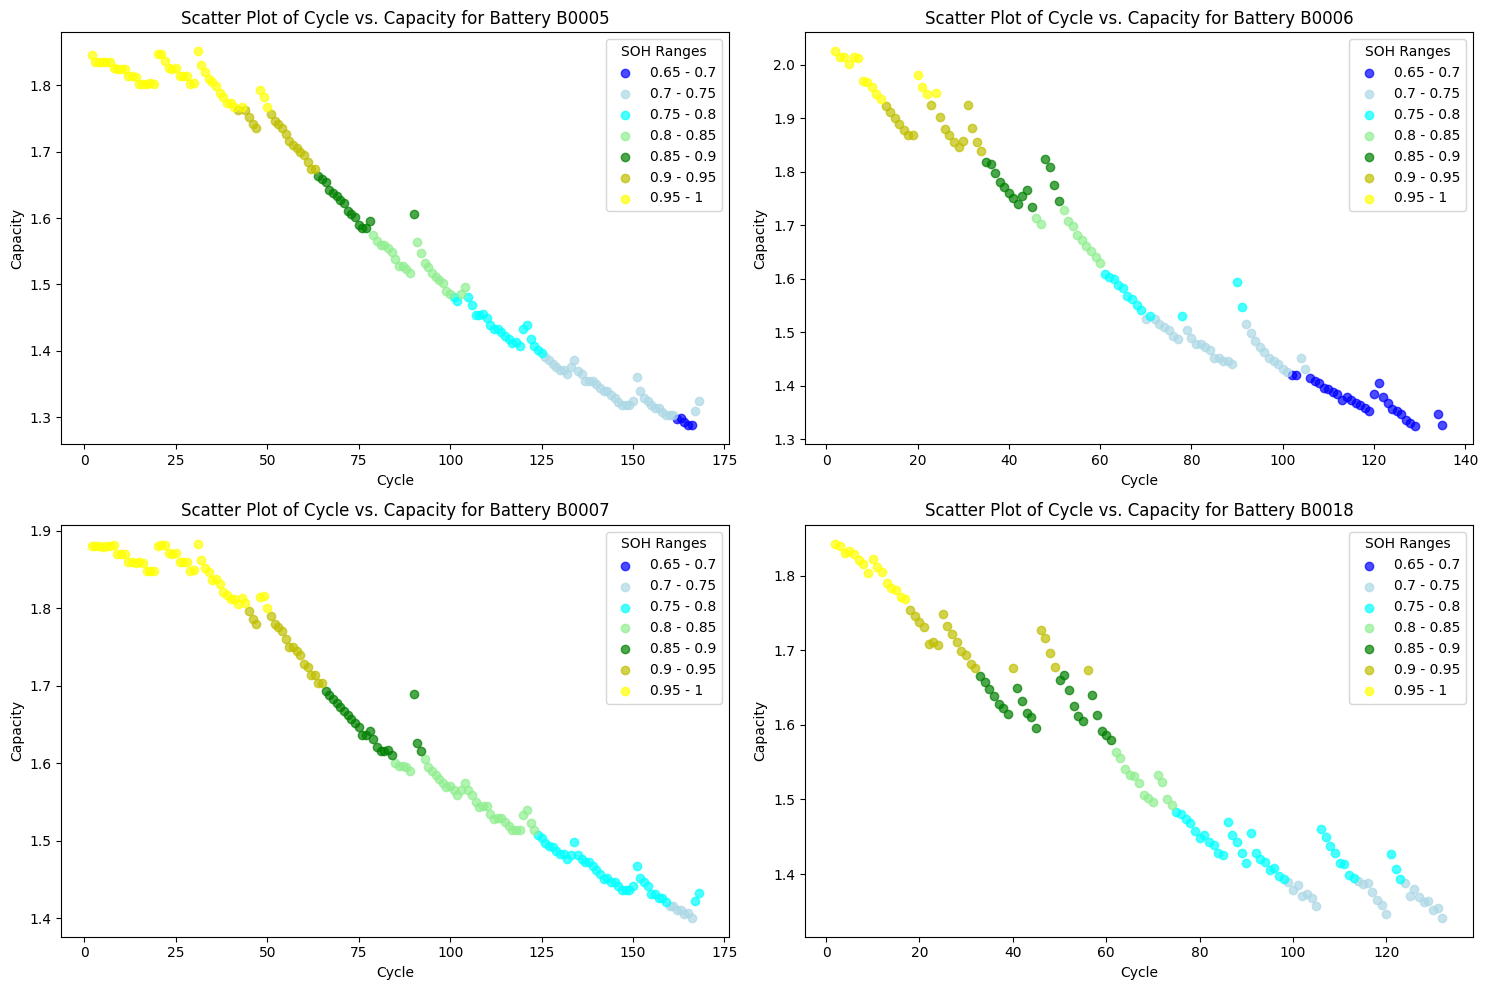

In [10]:
_, _, max_discharge_dfs = get_max_dfs(battery_dict)
plot_max_discharge_dfs(max_discharge_dfs)

In all four datasets, as the cycle number increases, the capacity decreases. This shows the expected degradation of the battery over time. Initially, the capacity starts high and gradually decreases, which is typical behavior in lithium-ion batteries.

The color gradient from yellow (high SOH) to blue (low SOH) indicates the reduction in battery health as the number of cycles increases. Earlier cycles have higher SOH values (yellow to green), and later cycles have lower SOH values (cyan to blue).

### Battery charge and discharge voltage and current measured

In [11]:
def get_voltage_current_plot(battery='B0005', type='charge', kind='voltage'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    battery_df = battery_dict[f'{battery}_{type}']

    ax.scatter(
        battery_df['Cycle'],
        battery_df['Time'],
        battery_df[f'{kind.title()}_measured'],
        c=battery_df['Cycle'],
        cmap='viridis'
    )

    ax.set_title(f'3D Plot of {kind.title()} during {type.title()}')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('Time')
    ax.set_zlabel(kind.title())

    ax.view_init(elev=15, azim=20)

    plt.show()

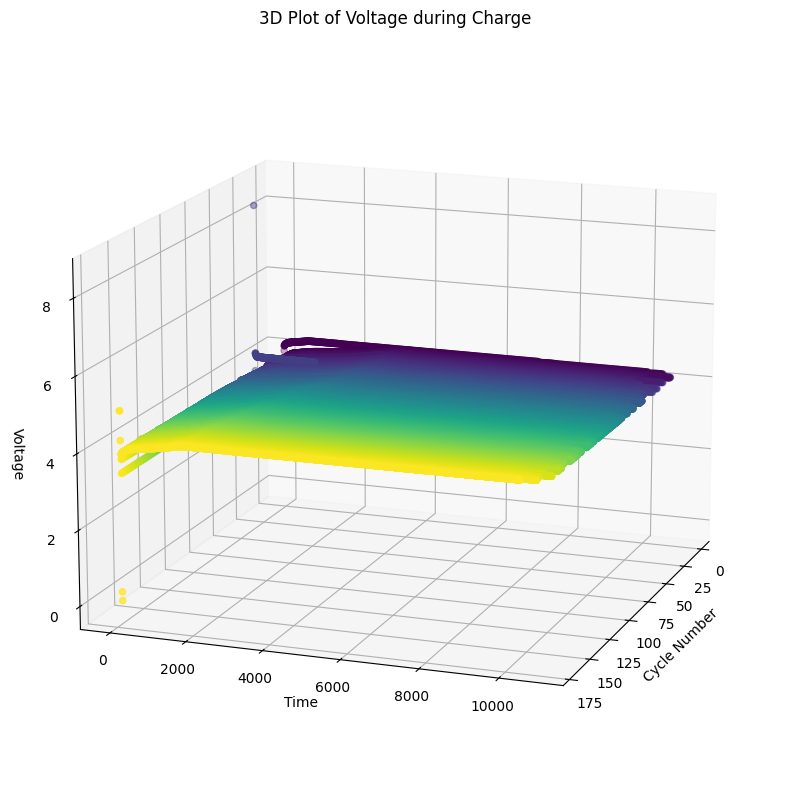

In [12]:
get_voltage_current_plot('B0005', 'charge', 'voltage')

The voltage during the charging process stabilizes quickly after an initial rise and remains consistent over many cycles. The battery shows stable performance, with no significant fluctuations in voltage as the charging cycles increase. The smooth and flat surface indicates a well-functioning battery with consistent charging characteristics throughout the observed cycles.

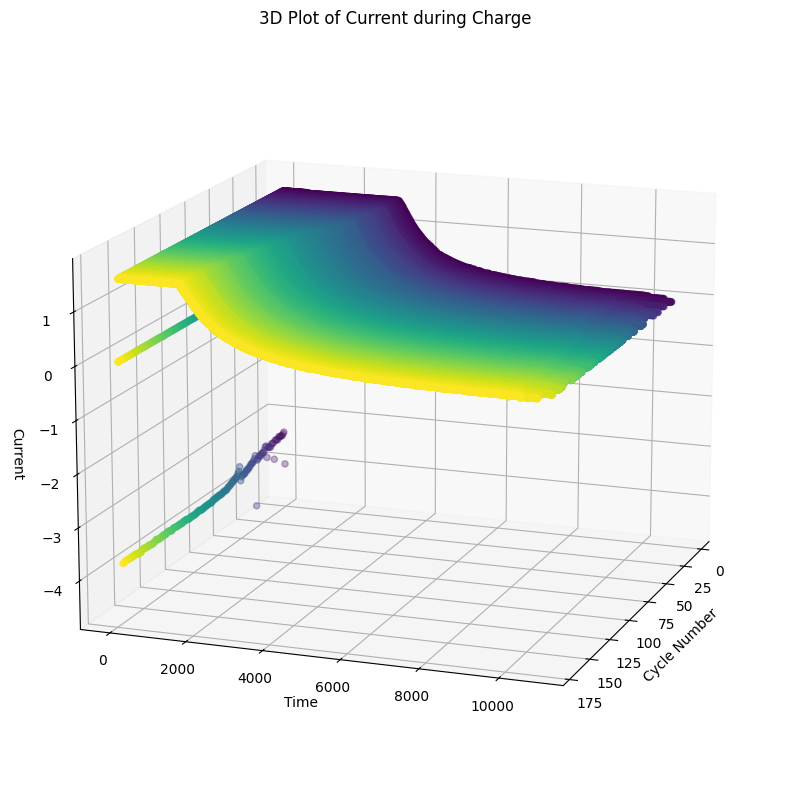

In [13]:
get_voltage_current_plot('B0005', 'charge', 'current')

The current begins at a higher negative value and then stabilizes towards zero as the charging progresses. The color gradient and smooth surface imply that the battery maintains similar charging behavior over time, with no major fluctuations in current patterns across the cycles.

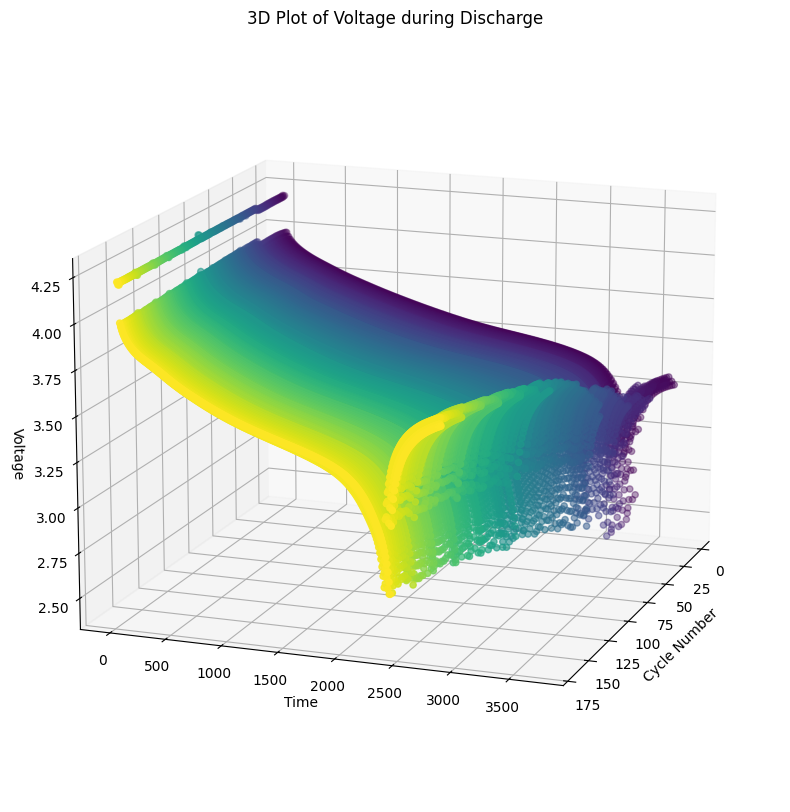

In [14]:
get_voltage_current_plot('B0005', 'discharge', 'voltage')

The plot illustrates the typical voltage decline during discharge for a battery across multiple cycles. In earlier cycles, the battery holds its voltage higher for longer periods, but as the cycle number increases, the battery's ability to maintain a high voltage decreases. The plot clearly shows the aging process of the battery, with voltage dropping more rapidly over time in later cycles, indicating reduced capacity and efficiency as the battery degrades.

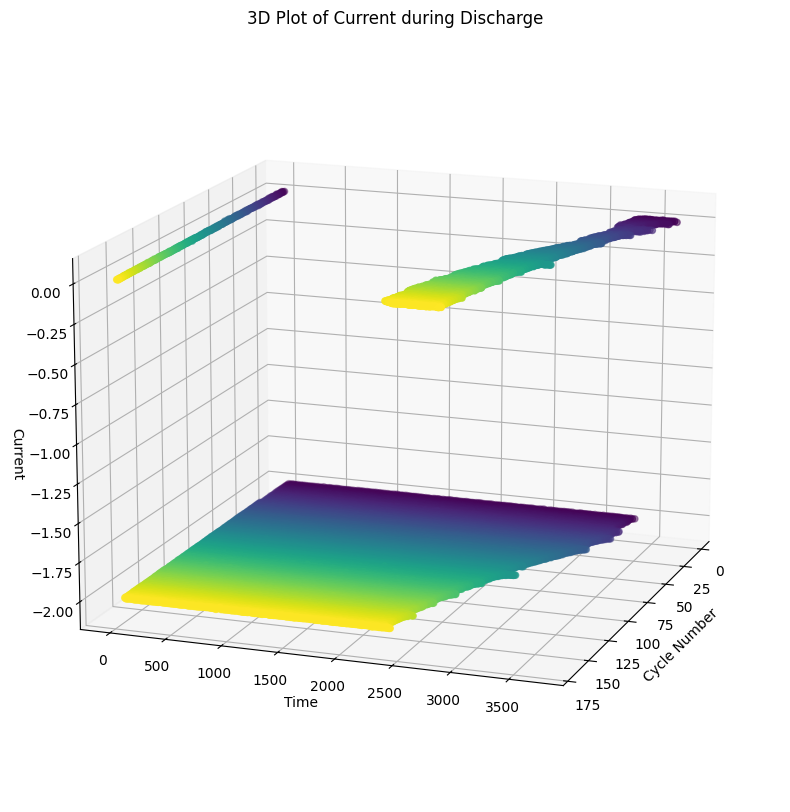

In [15]:
get_voltage_current_plot('B0005', 'discharge', 'current')

The plot indicates that the battery experiences a stable and consistent discharge current across both time and cycle number, with the current staying close to -2 amperes throughout the discharge process.

### Changes to battery capacity over cycles 

In [16]:
def get_capacity_plot(battery='B0005'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    battery_df = battery_dict[f'{battery}_discharge']

    ax.scatter(
        battery_df['Cycle'],
        battery_df['Time'],
        battery_df['Capacity'],
        c=battery_df['Cycle'],
        cmap='viridis'
    )

    ax.set_title(f'3D Plot of Capacity during Discharge')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('Time')
    ax.set_zlabel('Capacity')

    ax.view_init(elev=15, azim=-50)

    plt.show()

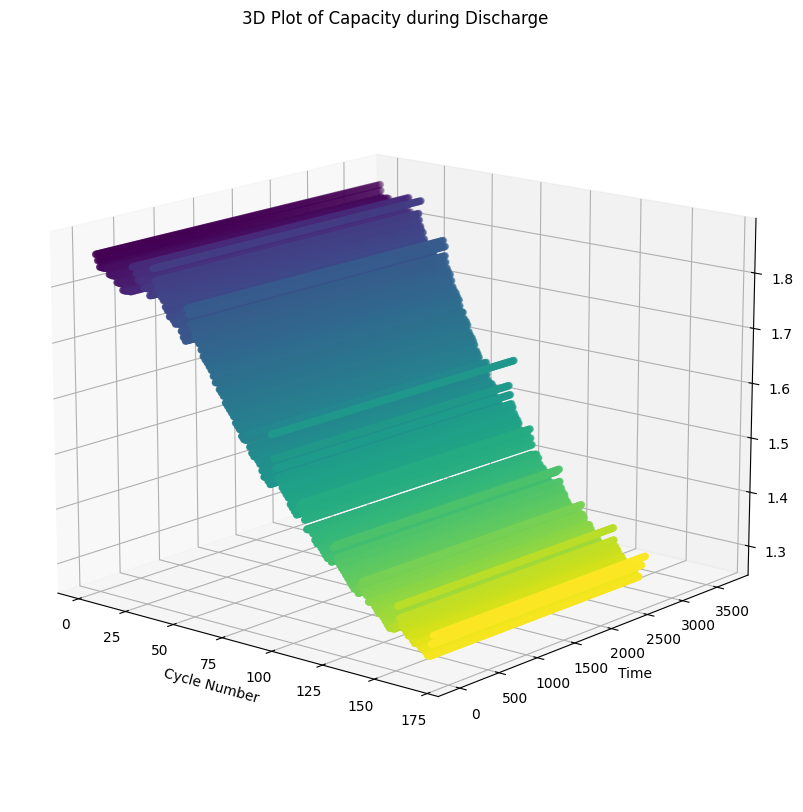

In [17]:
get_capacity_plot('B0005')

This plot demonstrates the battery's gradual capacity degradation during discharge over time and cycle number. The smooth decline from high to low capacity indicates consistent and predictable aging of the battery. As the cycle number increases, the battery's capacity steadily decreases, with the plot providing a clear visual representation of how the battery's ability to hold charge diminishes as it ages. 

## Comparing the first and last voltage/current for all the batteries

In [18]:
def get_first_last_voltage_plot(batteries=['B0005'], type='charge', kind='voltage', cycles=(1, 2)):
    num_batteries = len(batteries)
    rows = (num_batteries + 1) // 2

    plt.figure(figsize=(14, 4 * rows))

    for idx, battery in enumerate(batteries):
        battery_df = battery_dict[f'{battery}_{type}']
        last_cycle = cycles[1]

        if last_cycle not in battery_df['Cycle'].values:
            last_cycle = battery_df['Cycle'].max()

        cycle_first_df = battery_df[battery_df['Cycle'] == cycles[0]]
        cycle_last_df = battery_df[battery_df['Cycle'] == last_cycle]

        plt.subplot(rows, 2, idx + 1)

        plt.plot(cycle_first_df['Time'], cycle_first_df[f'{kind.title()}_measured'], 'b', label='First Cycle')
        plt.plot(cycle_last_df['Time'], cycle_last_df[f'{kind.title()}_measured'], 'r', label='Last Cycle')

        plt.title(f'{battery} First-Last {kind.title()} Plot')
        plt.xlabel('Time')
        plt.ylabel(f'{kind.title()}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

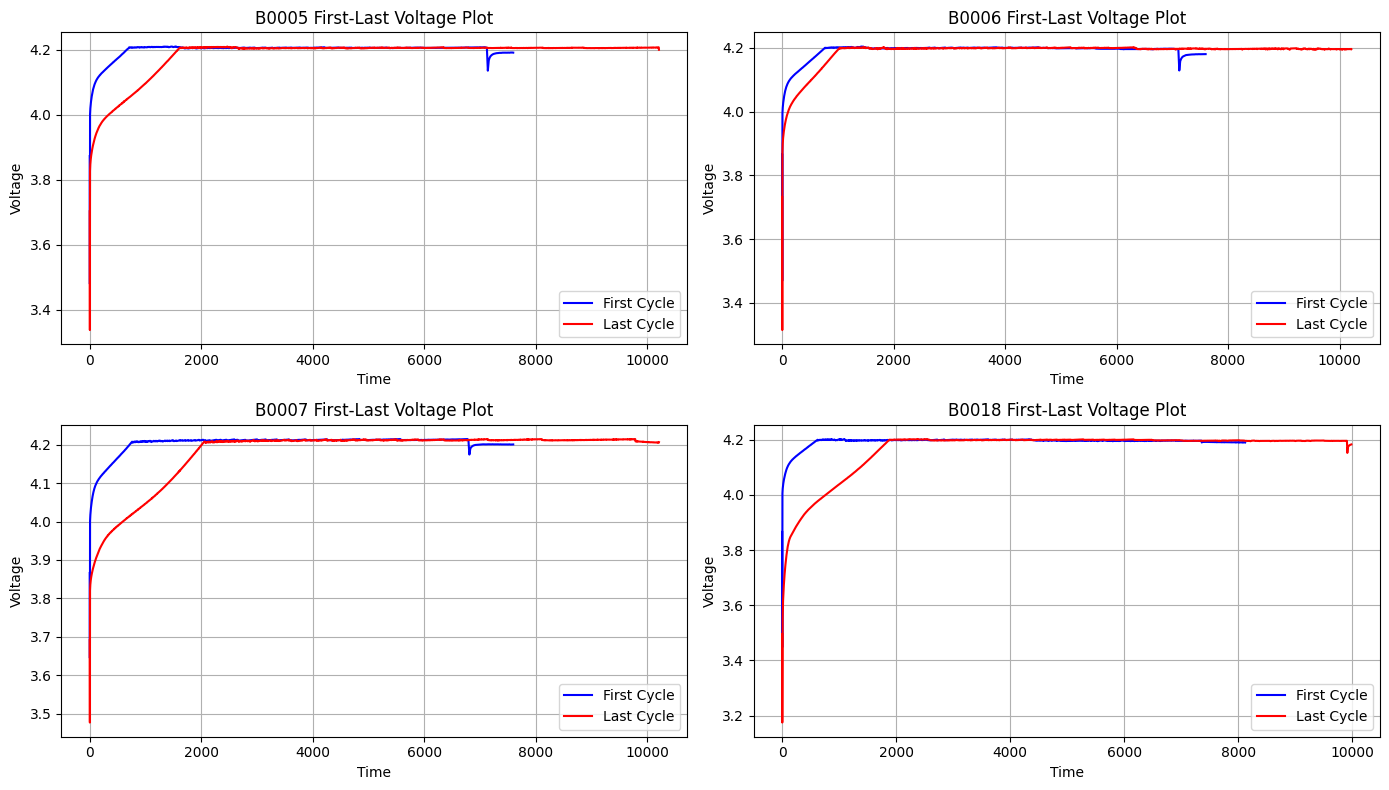

In [19]:
get_first_last_voltage_plot(battery_list, 'charge', 'voltage', (1, 169))

The four subplots display the voltage profiles of four different batteries (B0005, B0006, B0007, and B0018) during their first and last charging cycles. The voltage is plotted against time for each battery, with the first cycle in blue and the last cycle in red.

The red curve (last cycle) starts at a significantly lower voltage (~3.2V) compared to the blue curve (first cycle), which starts slightly above 3.4V. This indicates that the battery has degraded, and it begins charging at a lower voltage during the last cycle, a sign of reduced capacity and internal wear.

In the initial stages of charging, the blue curve (first cycle) rapidly increases and stabilizes near 4.2V. In contrast, the red curve (last cycle) shows a slower rise and a more gradual increase in voltage, indicating that the battery is struggling to charge as quickly as it did when it was new.

The blue curve reaches the voltage plateau more quickly, stabilizing at 4.2V earlier in the charging process. The red curve, however, takes longer to reach this plateau and does so less sharply. This implies that the battery has lost some of its ability to hold charge effectively, a typical sign of battery aging.

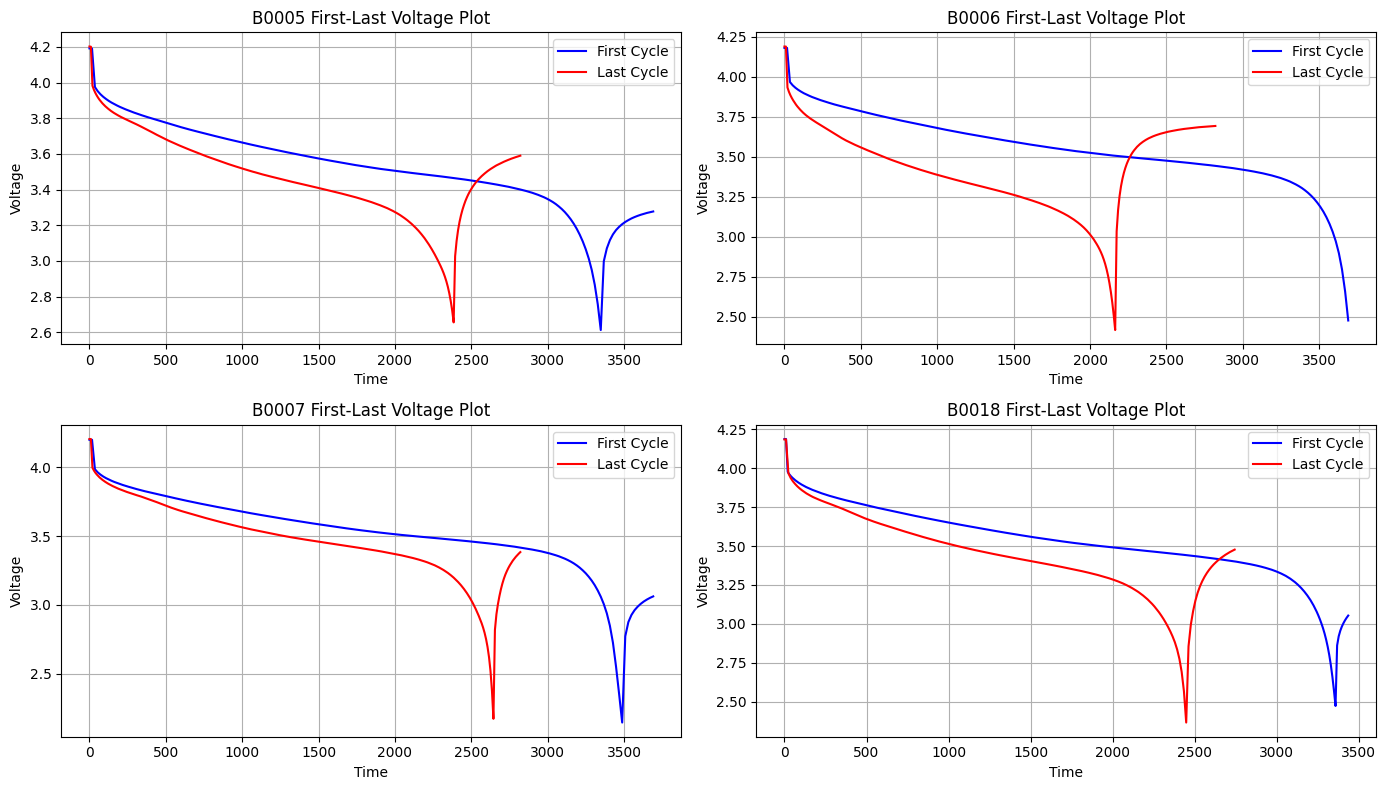

In [20]:
get_first_last_voltage_plot(battery_list, 'discharge', 'voltage', (1, 168))

In all plots, the voltage decreases steadily over time as the batteries discharge. The blue curves (first cycle) generally start at a slightly higher voltage and maintain a more gradual decline in voltage compared to the red curves (last cycle), which indicate faster voltage drops during the last cycle.

The red curves exhibit a more pronounced drop in voltage as compared to the blue curves in the mid-range of discharge. This indicates that as the batteries age, they lose their ability to sustain higher voltages over time and discharge more rapidly during the middle phase of the cycle.

Near the end of the discharge, there is a sudden sharp drop in voltage for both the first and last cycles (particularly evident around 3500 seconds). However, the red curves reach this sharp decline earlier than the blue curves, suggesting that as the battery ages, its capacity to sustain voltage diminishes more quickly, reaching lower voltages sooner.

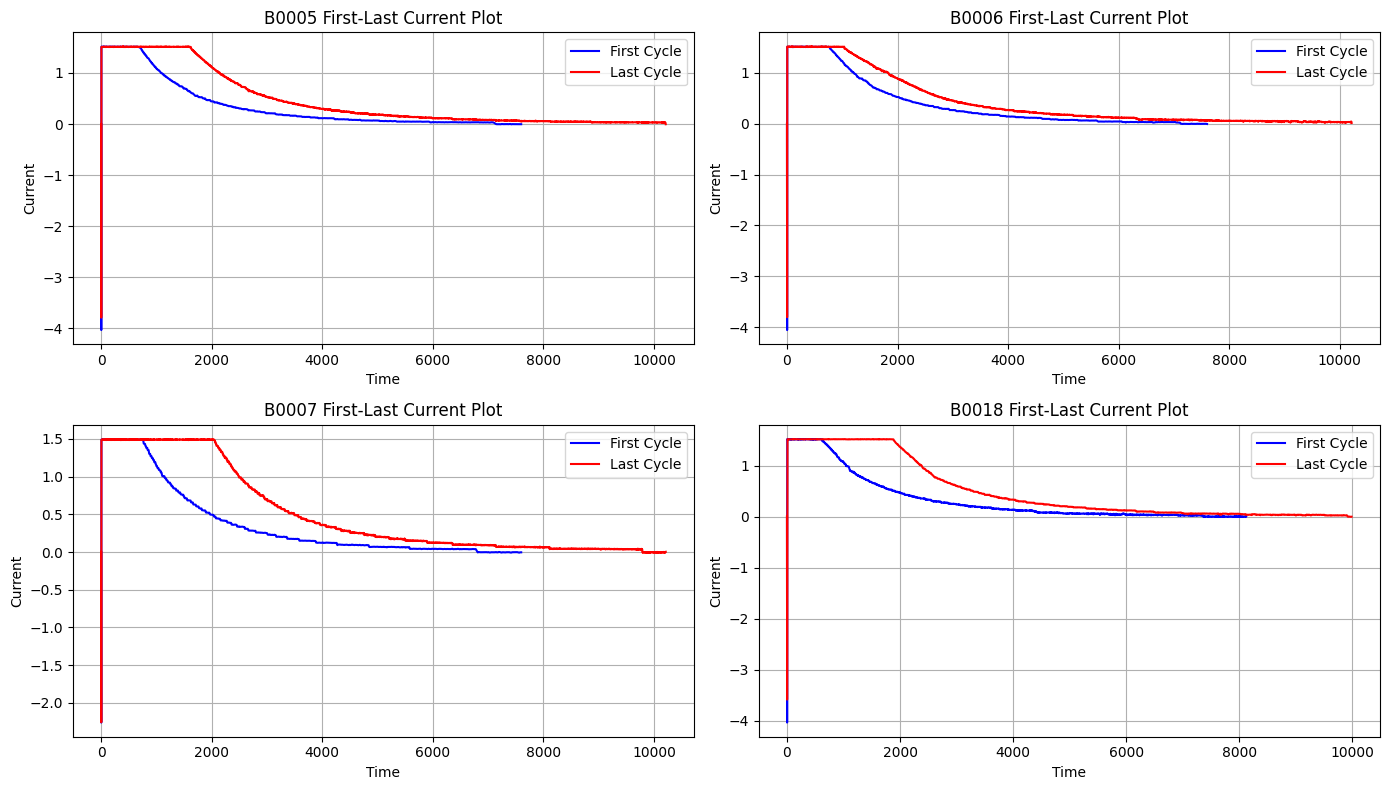

In [21]:
get_first_last_voltage_plot(battery_list, 'charge', 'current', (1, 169))

In all plots, both the first and last cycles start with a sharp increase in current at the beginning of the charging process. In the initial phases of charging, the current is relatively stable (constant current phase) before it begins to decline. The red curves (last cycles) have a more extended period of this constant current phase compared to the blue curves, indicating that aged batteries hold onto higher currents for longer during charging.

The current decreases gradually over time for both the first and last cycles. However, the red curves (last cycles) decline more slowly than the blue curves (first cycles). This suggests that older batteries take longer to reduce their current during charging, indicating a reduced efficiency in reaching a fully charged state.

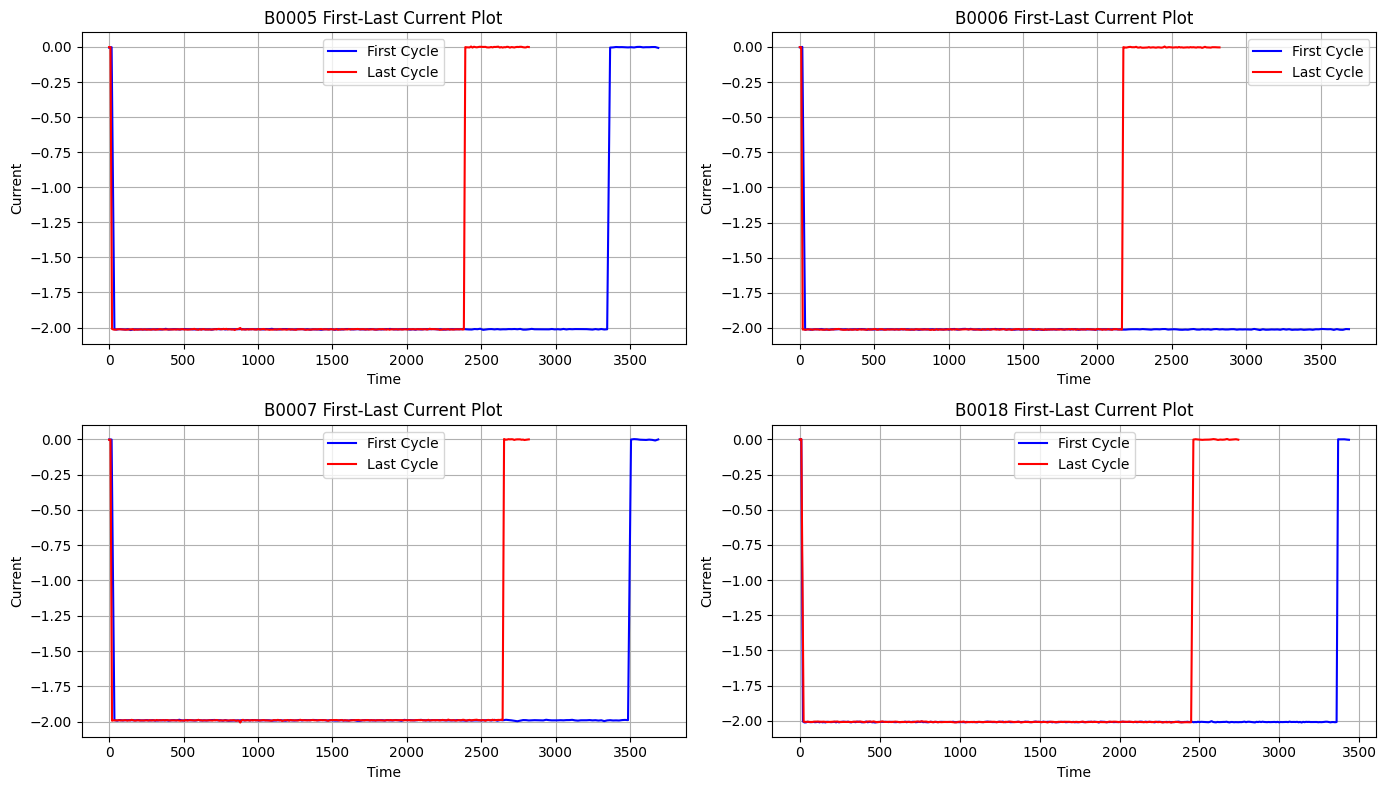

In [22]:
get_first_last_voltage_plot(battery_list, 'discharge', 'current', (1, 168))

All four batteries show an immediate drop in current at the beginning of the discharge process, quickly reaching around -2 A in both the first (blue) and last (red) cycles. This sharp drop indicates the batteries discharging under a constant current.

At the end of the discharge process, all four batteries show a sharp rise in current back to 0 A. However, the red curves (last cycle) show this increase happening earlier than in the blue curves (first cycle), indicating that the batteries in their last cycle discharge faster and reach the end of their discharge more quickly.

### Comparing the impedance for all the batteries

In the context of batteries, impedance represents the total opposition to current flow within the battery during charging and discharging. It varies with the battery's state of charge, temperature, and frequency of the applied current, and an increase in impedance is often a sign of battery degradation.

Electrolyte resistance (also known as ohmic resistance) refers to the resistance to the flow of ions within the electrolyte of a battery. The electrolyte is the medium through which ions travel between the anode and cathode during the charge and discharge cycles.

Charge transfer resistance is the resistance encountered during the transfer of charge between the electrode (either anode or cathode) and the electrolyte at the electrode-electrolyte interface. This resistance occurs due to the kinetics of the electrochemical reactions that convert electrical energy into chemical energy (or vice versa) during charging and discharging. 

In [23]:
def get_re_rct_plot(batteries=['B0005']):
    num_batteries = len(batteries)
    rows = (num_batteries + 1) // 2

    plt.figure(figsize=(14, 4 * rows))

    for idx, battery in enumerate(batteries):
        battery_df = battery_dict[f'{battery}_impedance']

        plt.subplot(rows, 2, idx + 1)

        plt.plot(battery_df['Test'], battery_df['Re'], 'r', label='Electrolyte Resistance')
        plt.plot(battery_df['Test'], battery_df['Rct'], 'b', label='Charge Transfer Resistance')

        plt.title(f'{battery} Re & Rct Plot')
        plt.xlabel('Test')
        plt.ylabel('Ohms')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

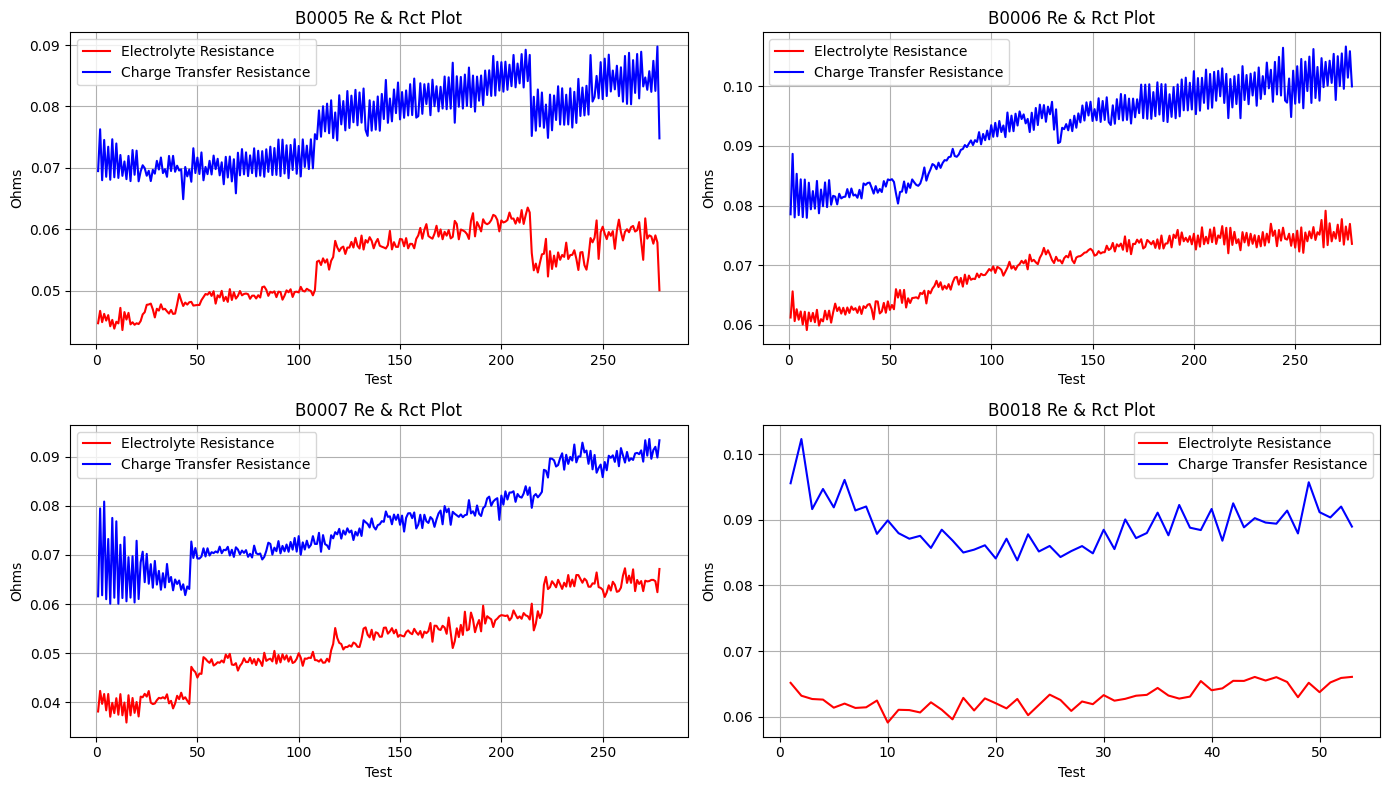

In [24]:
get_re_rct_plot(battery_list)

These plots suggest that electrolyte and charge transfer resistances are useful indicators of battery health. The increasing trends in charge transfer resistance and electrolyte resistance for B0005, B0006, and B0007 highlight the progressive aging of the batteries, while B0018 appears to have had more significant initial degradation, particularly in charge transfer resistance. As batteries age, higher resistance leads to lower performance, reduced capacity, and slower electrochemical reactions.

In [25]:
def get_first_last_impedance_plot(batteries=['B0005'], tests=(1, 2)):
    num_batteries = len(batteries)
    rows = (num_batteries + 1) // 2

    plt.figure(figsize=(14, 4 * rows))

    for idx, battery in enumerate(batteries):
        battery_df = battery_dict[f'{battery}_impedance']

        first_test_df = battery_df[battery_df['Test'] == tests[0]].copy()
        last_test = tests[1] if tests[1] in battery_df['Test'].values else battery_df['Test'].max()
        last_test_df = battery_df[battery_df['Test'] == last_test].copy()

        first_test_df.loc[:, 'Battery_impedance_real'] = np.real(first_test_df['Battery_impedance'].astype(complex))
        last_test_df.loc[:, 'Battery_impedance_real'] = np.real(last_test_df['Battery_impedance'].astype(complex))

        first_test_df.loc[:, 'Sample'] = np.arange(1, len(first_test_df) + 1)
        last_test_df.loc[:, 'Sample'] = np.arange(1, len(last_test_df) + 1)

        plt.subplot(rows, 2, idx + 1)
        plt.plot(first_test_df['Sample'], first_test_df['Battery_impedance_real'], 'b', label='First Test')
        plt.plot(last_test_df['Sample'], last_test_df['Battery_impedance_real'], 'r', label='Last Test')

        plt.title(f'{battery} First-Last Impedance Plot')
        plt.xlabel('Sample')
        plt.ylabel('Ohms')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

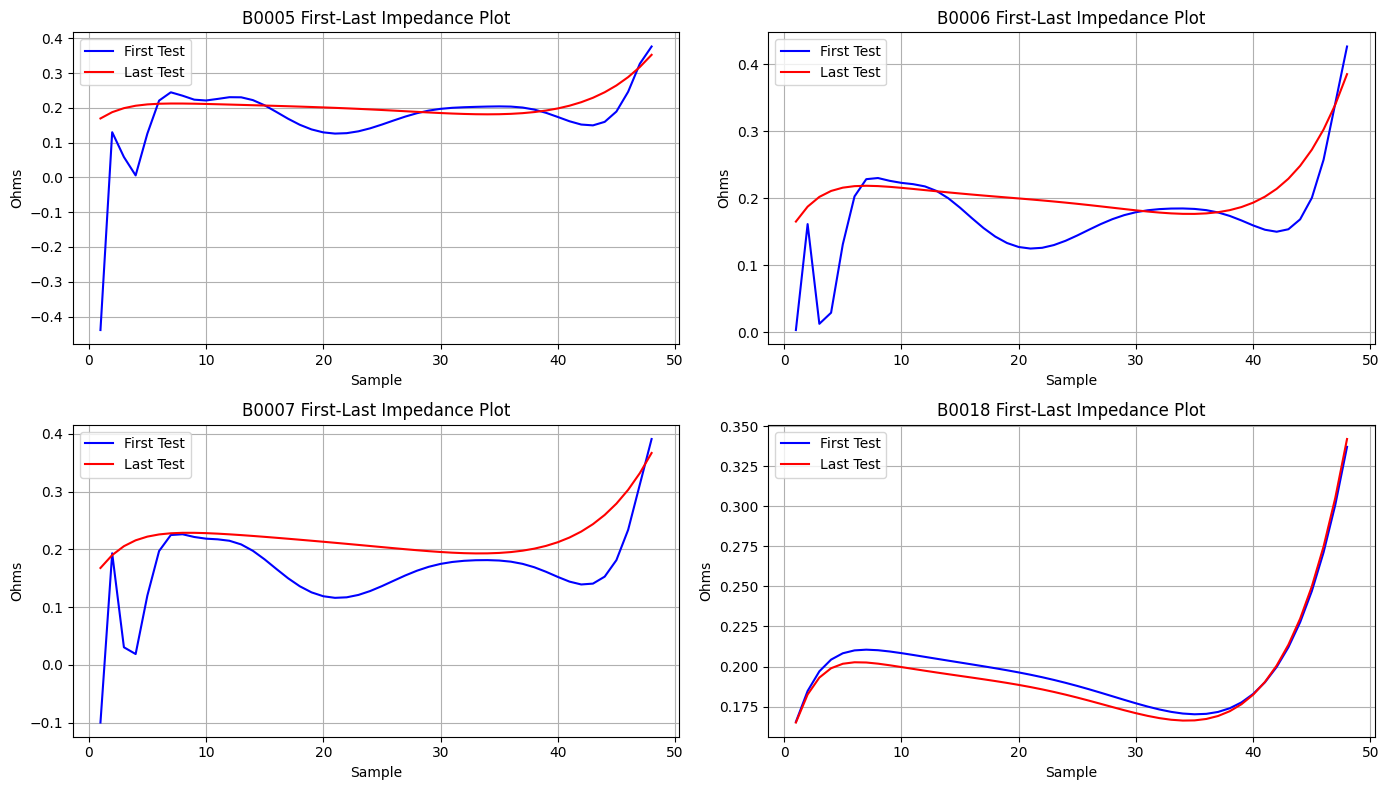

In [26]:
get_first_last_impedance_plot(battery_list, tests=(1, 278))

Across all four batteries, the impedance in the last test is higher than in the first test, a clear indication of battery aging. As batteries degrade, their internal components offer more resistance to the flow of current, reflected in higher impedance values.

The impedance fluctuations seen in the first tests are less pronounced in the last tests. This could be due to the internal stabilization of the battery components after experiencing initial degradation.

## Battery 5 Modelling

In [27]:
b5_discharge_df = battery_dict['B0005_discharge']
max_discharge_df = b5_discharge_df.loc[b5_discharge_df.groupby('Cycle')['Time'].idxmax()]
max_discharge_df

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,SOH
196,1,3690.234,3.277170,-0.006528,34.230853,-0.0006,0.0,1.856487,1.000000
392,2,3672.344,3.300245,-0.000448,34.392137,-0.0006,0.0,1.846327,0.994527
587,3,3651.641,3.327451,0.001026,34.232779,-0.0006,0.0,1.835349,0.988614
781,4,3631.563,3.314182,-0.002234,34.413450,-0.0006,0.0,1.835263,0.988567
975,5,3629.172,3.305497,0.000009,34.345885,-0.0006,0.0,1.834646,0.988235
...,...,...,...,...,...,...,...,...,...
49092,164,2793.390,3.615561,-0.002548,34.075649,0.0006,0.0,1.293464,0.696726
49389,165,2793.390,3.621191,-0.002460,33.991350,0.0006,0.0,1.288003,0.693785
49686,166,2792.485,3.619185,0.000478,34.059198,0.0006,0.0,1.287453,0.693488
49984,167,2802.016,3.595365,-0.002342,34.556514,0.0006,0.0,1.309015,0.705103


In [28]:
y = max_discharge_df['SOH']
X = max_discharge_df.drop(['SOH', 'Capacity', 'Cycle'], axis=1)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.svm import SVR

model = SVR(kernel='rbf')  # You can use other kernels like 'linear' or 'poly' if needed
model.fit(X_train, y_train)

SVR()

In [31]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 0.01


The  Mean Squared error is extremely low, meaning the predicted values are very close to the actual values

In [32]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3],
    'gamma': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVR(), parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.01}


C: 0.1 means our model is not overfitting but might have some bias. 

Epsilon : 0.1 means that there is a low tolerance to error


In [33]:
test_df = X_test.copy()
test_df['Actual SOH'] = y_test
test_df['Predicted SOH'] = y_pred
test_df['Cycle'] = max_discharge_df.loc[X_test.index, 'Cycle']

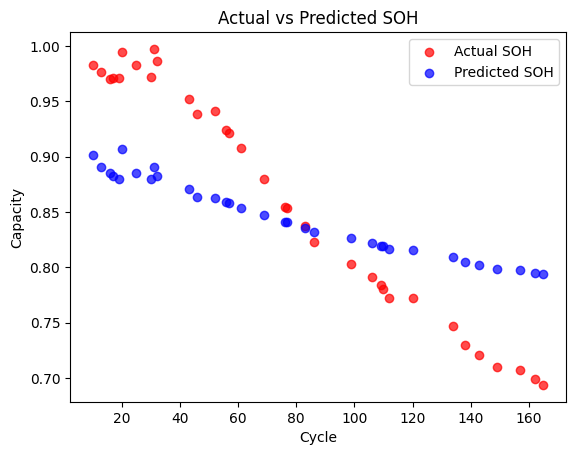

In [34]:
plt.scatter(test_df['Cycle'], test_df['Actual SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(test_df['Cycle'], test_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Actual vs Predicted SOH')
plt.legend()
plt.show()

Using base SVR did not yield good results as the predicted and actual values form a very different line

In [35]:
new_df = max_discharge_df.copy()

model = SVR(kernel='rbf')
model.fit(X, y)

y_pred = model.predict(X)
new_df['Predicted SOH'] = y_pred

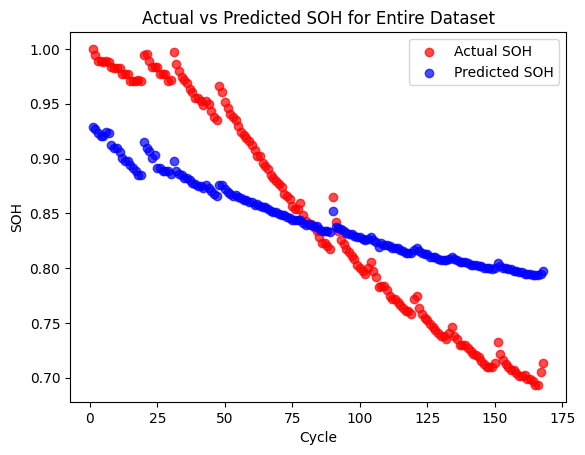

In [36]:
plt.scatter(new_df['Cycle'], new_df['SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(new_df['Cycle'], new_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.title('Actual vs Predicted SOH for Entire Dataset')
plt.legend()
plt.show()

As each cycle has one capacity value, we took that for discharge

We did not get good results with this SVR model either

In [37]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [38]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 0.00
R^2 Score: 0.99


In [39]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 0.00
R^2 Score: 0.99


In [40]:
test_df = X_test.copy()
test_df['Actual SOH'] = y_test
test_df['Predicted SOH'] = y_pred
test_df['Cycle'] = max_discharge_df.loc[X_test.index, 'Cycle']

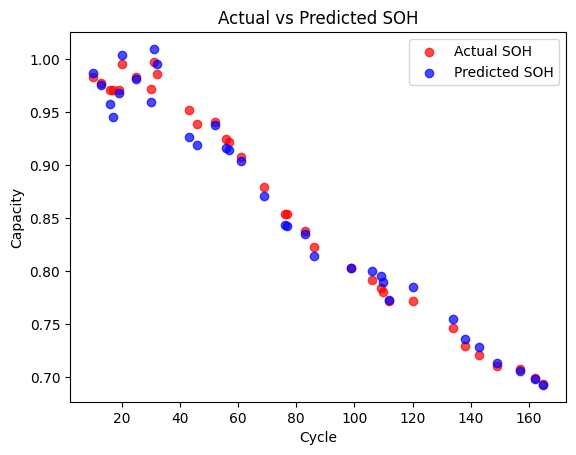

In [41]:
plt.scatter(test_df['Cycle'], test_df['Actual SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(test_df['Cycle'], test_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Actual vs Predicted SOH')
plt.legend()
plt.show()

The graph for the linear regression model reflects the results above as we can see that the actual versus predicted data points shows them overlapping almost perfectly

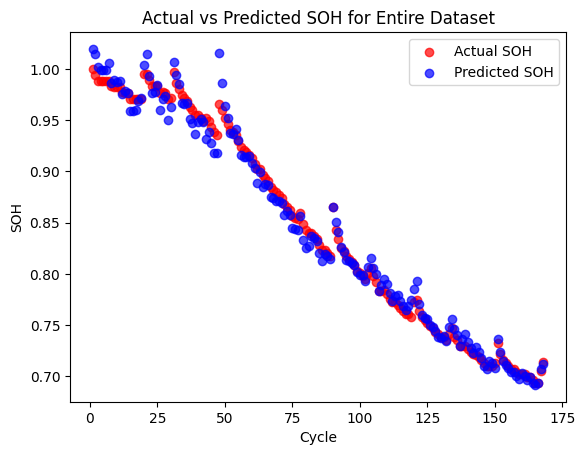

In [42]:
new_df = max_discharge_df.copy()

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
new_df['Predicted SOH'] = y_pred
plt.scatter(new_df['Cycle'], new_df['SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(new_df['Cycle'], new_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.title('Actual vs Predicted SOH for Entire Dataset')
plt.legend()
plt.show()

The linear regression model also shows excellent results with a lot of overlap between actual and predicted data points. This graph is the same model as above, but on the whole dataset

## Combining charge and discharge

In [43]:
battery_dict.keys()

dict_keys(['B0005_charge', 'B0005_discharge', 'B0005_impedance', 'B0006_charge', 'B0006_discharge', 'B0006_impedance', 'B0007_charge', 'B0007_discharge', 'B0007_impedance', 'B0018_charge', 'B0018_discharge', 'B0018_impedance'])

In [44]:
battery_dict['B0005_charge'].head(2)

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570


In [45]:
battery_dict['B0005_discharge'].head(2)

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,SOH
0,1,0.000,4.191492,-0.004902,24.330034,-0.0006,0.000,1.856487,1.0
1,1,16.781,4.190749,-0.001478,24.325993,-0.0006,4.206,1.856487,1.0


In [46]:
def combine_dataset(battery_dictionary):
    combine_dfs = []

    for battery_name, battery_data in battery_dictionary.items():
        if 'impedance' not in battery_name:
            battery_df = battery_data.copy()
            battery_df['Battery'] = battery_name.split('_')[0]

            if '_charge' in battery_name:
                battery_df['Type'] = 'Charge'
            else:
                battery_df['Type'] = 'Discharge'

            combine_dfs.append(battery_df)

    combined_df = pd.concat(combine_dfs, ignore_index=True)
    return combined_df

In [47]:
total_battery_df = combine_dataset(battery_dict)
total_battery_df = total_battery_df.drop(columns=['SOH'])
total_battery_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Battery,Type,Capacity
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003,B0005,Charge,NaN
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570,B0005,Charge,NaN
2,1,5.500,4.000588,1.512731,24.675394,1.500,4.726,B0005,Charge,NaN
3,1,8.344,4.012395,1.509063,24.693865,1.500,4.742,B0005,Charge,NaN
4,1,11.125,4.019708,1.511318,24.705069,1.500,4.753,B0005,Charge,NaN


In [48]:
def fill_missing_capacity_soh(df):
    # grouped = df.groupby(['Battery', 'Cycle'])
    # df['Capacity'] = grouped['Capacity'].transform(lambda x: x.ffill().bfill())

    def fill_group(group):
        capacity_value = group['Capacity'].dropna().unique()

        if len(capacity_value) == 1:
            group['Capacity'] = capacity_value[0]

        return group

    df = df.groupby(['Battery', 'Cycle']).apply(fill_group)

    return df.reset_index(drop=True)

In [49]:
total_battery_df = fill_missing_capacity_soh(total_battery_df)
total_battery_df.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20140\2469746174.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['Battery', 'Cycle']).apply(fill_group)


,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Battery,Type,Capacity
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003,B0005,Charge,1.856487
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570,B0005,Charge,1.856487
2,1,5.500,4.000588,1.512731,24.675394,1.500,4.726,B0005,Charge,1.856487
3,1,8.344,4.012395,1.509063,24.693865,1.500,4.742,B0005,Charge,1.856487
4,1,11.125,4.019708,1.511318,24.705069,1.500,4.753,B0005,Charge,1.856487


In [50]:
def get_missing_data(df):
    missing_data = df.isnull().sum().reset_index()
    missing_data.columns = ['Column', 'Missing Count']
    missing_data['Missing Percentage'] = (missing_data['Missing Count'] / len(df)) * 100
    return missing_data.sort_values(by='Missing Percentage', ascending=False)


get_missing_data(total_battery_df)

,Column,Missing Count,Missing Percentage
9,Capacity,13692,0.655418
2,Voltage_measured,2,0.000096
3,Current_measured,2,0.000096
4,Temperature_measured,2,0.000096
0,Cycle,0,0.000000
1,Time,0,0.000000
5,Current_charge,0,0.000000
6,Voltage_charge,0,0.000000
7,Battery,0,0.000000
8,Type,0,0.000000


In [51]:
rows_with_missing_data = total_battery_df[total_battery_df.isnull().any(axis=1)]
rows_with_missing_data

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Battery,Type,Capacity
587849,169,0.000,3.703203,-0.004051,24.671571,0.000,0.003,B0005,Charge,NaN
587850,169,2.484,3.337711,-3.788460,24.675326,-3.788,1.511,B0005,Charge,NaN
587851,169,5.109,3.827229,1.510266,24.685090,1.498,4.558,B0005,Charge,NaN
587852,169,7.609,3.839275,1.510364,24.693961,1.500,4.580,B0005,Charge,NaN
587853,169,10.140,3.847181,1.511206,24.705552,1.500,4.586,B0005,Charge,NaN
...,...,...,...,...,...,...,...,...,...,...
2089045,134,9956.984,4.180760,-0.001612,23.160264,0.000,-0.007,B0018,Charge,NaN
2089046,134,9964.031,4.181660,-0.002837,23.166556,0.000,-0.007,B0018,Charge,NaN
2089047,134,9971.078,4.182311,-0.002382,23.163557,0.000,-0.007,B0018,Charge,NaN
2089048,134,9978.125,4.182857,-0.002210,23.153626,0.000,-0.007,B0018,Charge,NaN


In [52]:
total_battery_df = total_battery_df.dropna()
total_battery_df

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Battery,Type,Capacity
0,1,0.000,3.873017,-0.001201,24.655358,0.0000,0.003,B0005,Charge,1.856487
1,1,2.532,3.479394,-4.030268,24.666480,-4.0360,1.570,B0005,Charge,1.856487
2,1,5.500,4.000588,1.512731,24.675394,1.5000,4.726,B0005,Charge,1.856487
3,1,8.344,4.012395,1.509063,24.693865,1.5000,4.742,B0005,Charge,1.856487
4,1,11.125,4.019708,1.511318,24.705069,1.5000,4.753,B0005,Charge,1.856487
...,...,...,...,...,...,...,...,...,...,...
2086180,132,2686.359,3.443760,-0.002426,35.383979,0.0006,0.000,B0018,Discharge,1.341051
2086181,132,2700.546,3.453271,-0.000981,35.179732,0.0006,0.000,B0018,Discharge,1.341051
2086182,132,2714.640,3.461963,0.000209,34.977000,0.0006,0.000,B0018,Discharge,1.341051
2086183,132,2728.750,3.469907,0.001516,34.785943,0.0006,0.000,B0018,Discharge,1.341051


In [53]:
get_missing_data(total_battery_df)

,Column,Missing Count,Missing Percentage
0,Cycle,0,0.0
1,Time,0,0.0
2,Voltage_measured,0,0.0
3,Current_measured,0,0.0
4,Temperature_measured,0,0.0
5,Current_charge,0,0.0
6,Voltage_charge,0,0.0
7,Battery,0,0.0
8,Type,0,0.0
9,Capacity,0,0.0


## Modelling Proper

In [54]:
b18_df = total_battery_df[total_battery_df.Battery == 'B0018']
b18_df = b18_df.drop('Battery', axis=1)
b18_df = pd.get_dummies(b18_df, columns=['Type'], drop_first=True)
b18_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,Type_Discharge
1774374,1,0.000,3.865713,0.001014,23.735721,0.000,-0.007,1.855005,False
1774375,1,2.484,3.447651,-4.034445,23.743956,-4.036,1.553,1.855005,False
1774376,1,5.109,4.005559,1.517435,23.773723,1.507,4.721,1.855005,False
1774377,1,7.562,4.015989,1.514558,23.777077,1.507,4.737,1.855005,False
1774378,1,10.062,4.023230,1.517284,23.792710,1.507,4.743,1.855005,False


In [55]:
battery_df = total_battery_df[total_battery_df['Battery'].isin(['B0005', 'B0006', 'B0007'])].drop(columns=['Battery'])
battery_df

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Type,Capacity
0,1,0.000,3.873017,-0.001201,24.655358,0.0000,0.003,Charge,1.856487
1,1,2.532,3.479394,-4.030268,24.666480,-4.0360,1.570,Charge,1.856487
2,1,5.500,4.000588,1.512731,24.675394,1.5000,4.726,Charge,1.856487
3,1,8.344,4.012395,1.509063,24.693865,1.5000,4.742,Charge,1.856487
4,1,11.125,4.019708,1.511318,24.705069,1.5000,4.753,Charge,1.856487
...,...,...,...,...,...,...,...,...,...
1770760,168,2781.312,3.336677,-0.002464,38.744012,0.0006,0.001,Discharge,1.432455
1770761,168,2791.062,3.349952,-0.005358,38.462399,0.0006,0.001,Discharge,1.432455
1770762,168,2800.828,3.362104,-0.003906,38.246805,0.0006,0.001,Discharge,1.432455
1770763,168,2810.640,3.373357,-0.002763,37.970504,0.0006,0.001,Discharge,1.432455


In [56]:
battery_df = pd.get_dummies(battery_df, columns=['Type'], drop_first=True)
battery_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,Type_Discharge
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003,1.856487,False
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570,1.856487,False
2,1,5.500,4.000588,1.512731,24.675394,1.500,4.726,1.856487,False
3,1,8.344,4.012395,1.509063,24.693865,1.500,4.742,1.856487,False
4,1,11.125,4.019708,1.511318,24.705069,1.500,4.753,1.856487,False


In [57]:
y = battery_df['Capacity']
X = battery_df.drop('Capacity', axis=1)

In [58]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [59]:
y_train = y
X_train = sc.fit_transform(X)

y_test = b18_df['Capacity']
X_test = sc.fit_transform(b18_df.drop('Capacity', axis=1))

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def model_eval(y_test, prediction_dict):
    eval_results = {}

    for model_name, y_pred in prediction_dict.items():
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        mask = y_test != 0
        mape = np.mean(np.abs((y_test[mask] - y_pred[mask])) / y_test[mask]) * 100

        r2 = r2_score(y_test, y_pred)

        eval_results[model_name] = {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2 Score': r2
        }

    eval_df = pd.DataFrame(eval_results).T
    eval_df['Model'] = eval_df.index
    eval_df.reset_index(drop=True, inplace=True)

    return eval_df

## LinearSVR

In [61]:
from sklearn.svm import LinearSVR

linear_svr_model = LinearSVR(random_state=42)
linear_svr_model.fit(X_train, y_train)

C:\Users\ADMIN\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(random_state=42)

In [62]:
y_pred_lsvr = linear_svr_model.predict(X_test)

## Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [64]:
y_pred_lr = linear_svr_model.predict(X_test)

## SGDRegressor

In [65]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RepeatedKFold

sgd_regressor = SGDRegressor(max_iter=1000)

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=101)

param_sgd = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'fit_intercept': [True, False],
    'eta0': [0.1, 0.01, 0.001],
    'penalty': ['elasticnet', 'l1', 'l2']
}

search_sgd = GridSearchCV(sgd_regressor, param_sgd, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)

result_sgd = search_sgd.fit(X_train, y_train)
y_pred_sgd = search_sgd.predict(X_test)

In [66]:
print(f'Root Mean Square Error: {-result_sgd.best_score_:.4f}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred_sgd):.4f}')
print(f'R2 Score: {r2_score(y_test, y_pred_sgd):.4f}')
print('Best Hyperparameters:', result_sgd.best_params_)

Root Mean Square Error: 0.0657
Mean Absolute Error: 0.0537
R2 Score: 0.8270
Best Hyperparameters: {'alpha': 0.0001, 'eta0': 0.001, 'fit_intercept': True, 'penalty': 'l2'}


RMSE: 0.0657 indicates that the average error in the predictions is quite small

MAE: 0.0540 indicates on average, the predictions are off by about 0.054 units from the actual values, which is quite small

R squared : 0.8254 indicates 82.54% of the variance in the target variable is explained by the model. 

Alpha: 0.001  A small value like 0.0001 indicates minimal regularization, which suggests the model may be more flexible in fitting the data.

eta: .001 A small value like 0.001 implies that the model’s weight updates are gradual.

fit_intercept: model with include intercept

penalty: l2  which is ridge

## XGBoost

In [67]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)

xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [68]:
y_pred_xgb = xgb_regressor.predict(X_test)

In [69]:
prediction_dict = {
    'Linear Regression': y_pred_lr,
    'LinearSVR': y_pred_lsvr,
    'SGD Regressor': y_pred_sgd,
    'XGBoost Regressor': y_pred_xgb
}

eval_df = model_eval(y_test, prediction_dict)
eval_df

,RMSE,MAE,MAPE,R2 Score,Model
0,0.073442,0.059275,3.862844,0.786648,Linear Regression
1,0.073442,0.059275,3.862844,0.786648,LinearSVR
2,0.066142,0.053667,3.452325,0.826951,SGD Regressor
3,0.058610,0.045650,2.975731,0.864123,XGBoost Regressor


Xgboost outperforms every other model in every parameter

In [70]:
def plot_scores(df):
    score_types = {
        'RMSE': 'skyblue',
        'MAE': 'lightgreen',
        'MAPE': 'salmon',
        'R2 Score': 'orange'
    }

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    axs = axs.flatten()

    for idx, (score_type, color) in enumerate(score_types.items()):
        axs[idx].plot(df['Model'], df[score_type], color=color, marker='o', linestyle='-', linewidth=2, markersize=8,
                      label='Line')
        axs[idx].scatter(df['Model'], df[score_type], color=color, s=100, label='Points')

        axs[idx].set_title(score_type)
        axs[idx].set_ylabel(score_type.split()[0])
        axs[idx].legend()

        axs[idx].set_xticks(df['Model'])
        axs[idx].set_xticklabels(df['Model'], rotation=45, ha='right')
        axs[idx].get_legend().remove()

    plt.tight_layout()
    plt.show()

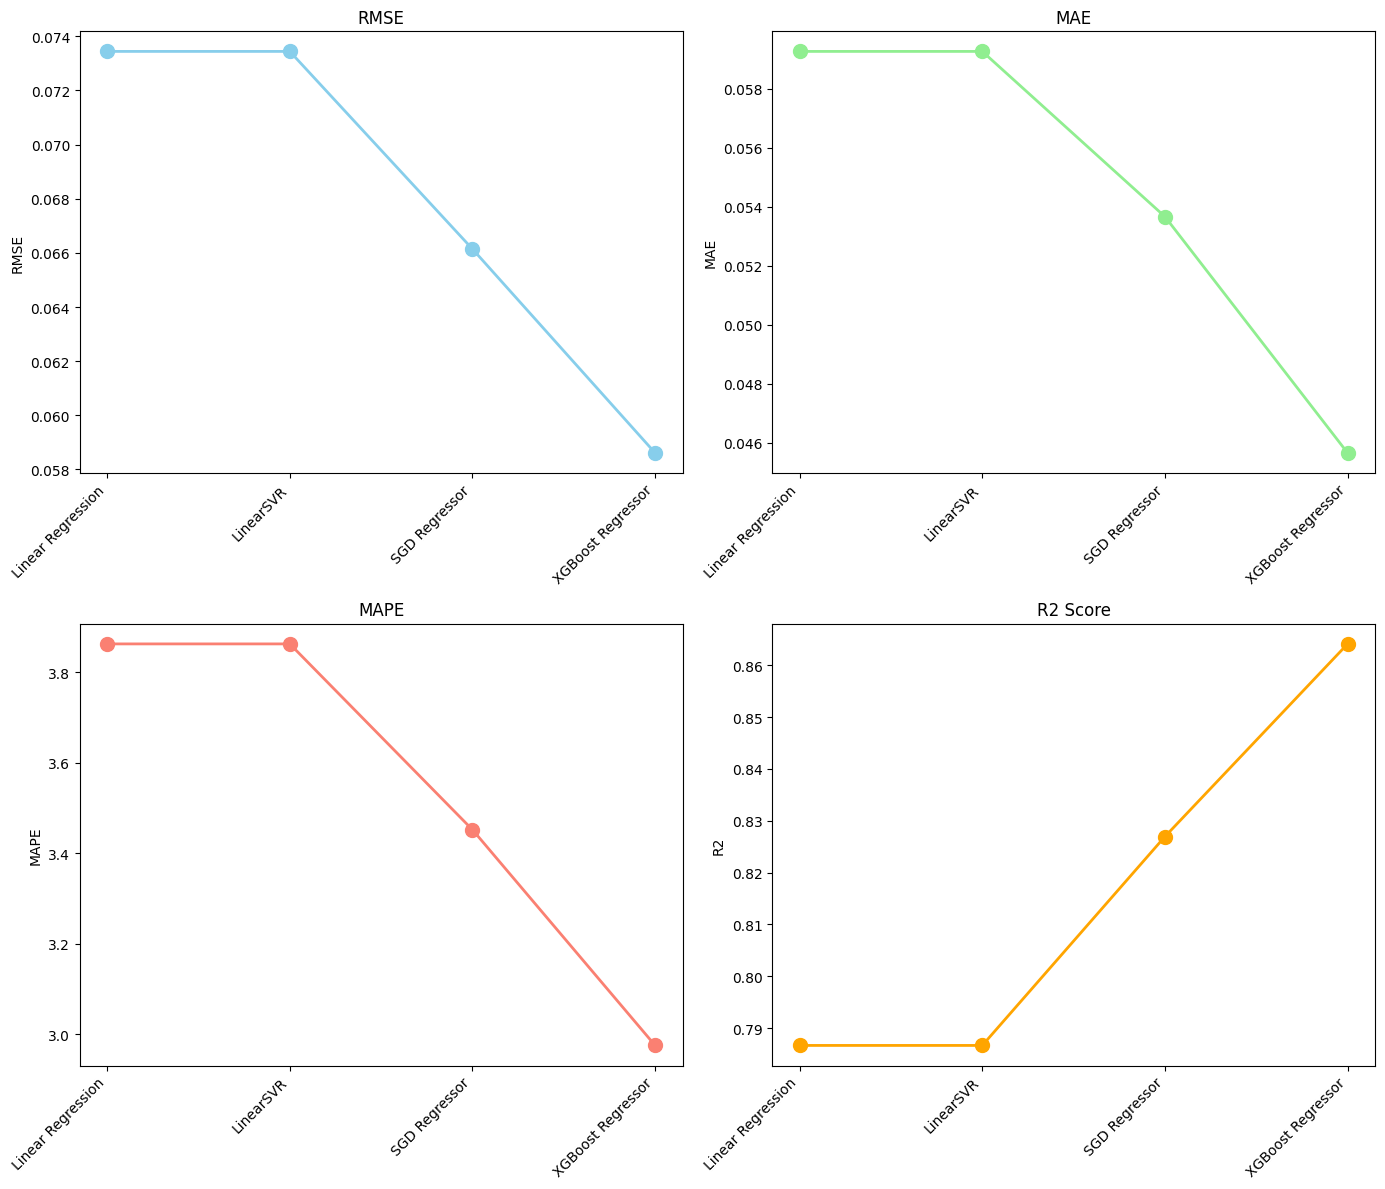

In [71]:
plot_scores(eval_df)

This plot exemplifies how much better xgboost is compared to the other models